## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.spatial.distance as dist


In [2]:
from scipy.optimize import curve_fit

## Read CSV

In [3]:
# Remember to remove the first two and the last three rows from the raw data file.
# They would cause pd.read_csv to break.
df=pd.read_csv('CLMTEMP_HKS_2020.csv')

## Print dataframe

In [4]:
pd.set_option('display.max_rows', 10)
df


,年/Year,月/Month,日/Day,數值/Value,數據完整性/data Completeness
0,2020,1,1,17.5,C
1,2020,1,2,18.0,C
2,2020,1,3,18.7,C
3,2020,1,4,18.5,C
4,2020,1,5,20.4,C
...,...,...,...,...,...
361,2020,12,27,19.9,C
362,2020,12,28,20.0,C
363,2020,12,29,20.6,C
364,2020,12,30,15.4,C


In [5]:
print(df.columns)

Index(['年/Year', '月/Month', '日/Day', '數值/Value', '數據完整性/data Completeness'], dtype='object')


In [6]:
print(df.dtypes) 
#notice that the type of Value is 'object' instead of 'float'. They would cause problem unless they are converted to float.

年/Year                      int64
月/Month                     int64
日/Day                       int64
數值/Value                   object
數據完整性/data Completeness    object
dtype: object


## Tidying up data - Transform incomplete data to NaN

In [7]:
df=df.replace('***',np.nan) 

## Tidying up data - Simplify column labels

In [8]:
df=df.rename(columns={'年/Year':'year',
                      '月/Month':'month',
                      '日/Day':'day',
                      '數值/Value':'value',
                      '數據完整性/data Completeness':'completeness'})

## Transforming Data (1) - slide 8 & 9 of lab 6

In [9]:
# Convert 'value' to float type
df['value']=df['value'].astype(float)

# Make a "Full Date" column using pd.to_datetime.
# pd.to_datetime requires the column labels to be 'year', 'month', and 'day'.
df['fulldate']=pd.to_datetime(df[['year','month','day']])

# Reorder the columns
columns_titles_order=['year','month','day','fulldate','value','completeness']
df=df.reindex(columns=columns_titles_order)

In [10]:
# Create a "Date Num" column
df['day_num']=range(1,367)

In [11]:
df

,year,month,day,fulldate,value,completeness,day_num
0,2020,1,1,2020-01-01,17.5,C,1
1,2020,1,2,2020-01-02,18.0,C,2
2,2020,1,3,2020-01-03,18.7,C,3
3,2020,1,4,2020-01-04,18.5,C,4
4,2020,1,5,2020-01-05,20.4,C,5
...,...,...,...,...,...,...,...
361,2020,12,27,2020-12-27,19.9,C,362
362,2020,12,28,2020-12-28,20.0,C,363
363,2020,12,29,2020-12-29,20.6,C,364
364,2020,12,30,2020-12-30,15.4,C,365


## Visulizing Data - Raw data

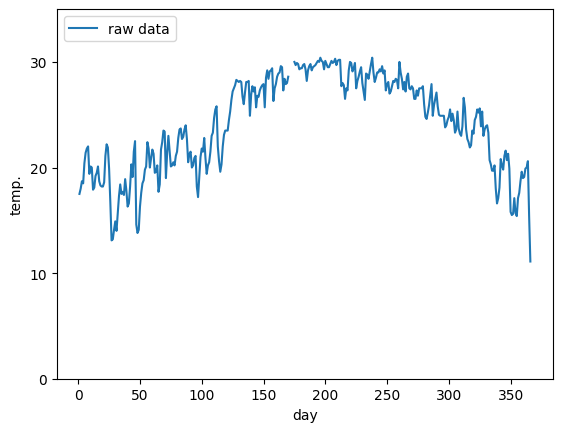

In [12]:
plt.figure()
plt.plot(df['day_num'],df['value'],label='raw data')

plt.ylim([0,35])
plt.yticks(np.arange(0,35,10))
plt.legend(loc="upper left")
plt.xlabel('day')
plt.ylabel('temp.')

plt.show()

## Visulize Data - Moving Average

[  17.5          35.5          54.2          72.7          93.1
  114.5         136.3         158.3         177.7         197.8
  217.8         235.7         253.8         273.          292.5
  312.6         331.3         349.6         367.8         386.
  404.6         425.7         447.9         469.8         489.7
  506.4         519.5         532.7         546.8         561.7
  575.7         591.3         608.6         627.          644.5
  662.2         679.6         698.5         716.3         732.6
  749.2         767.4         787.7         806.8         828.3
  850.8         865.4         879.2         893.3         909.6
  927.2         945.7         964.5         984.3        1004.4
 1026.8        1048.6        1068.6        1089.5        1111.2
 1132.5        1152.         1171.6        1191.8        1209.5
 1227.9        1249.6        1272.         1295.5        1318.9
 1337.9        1359.3        1382.3        1403.9        1424.
 1444.2        1464.7        1484.9       

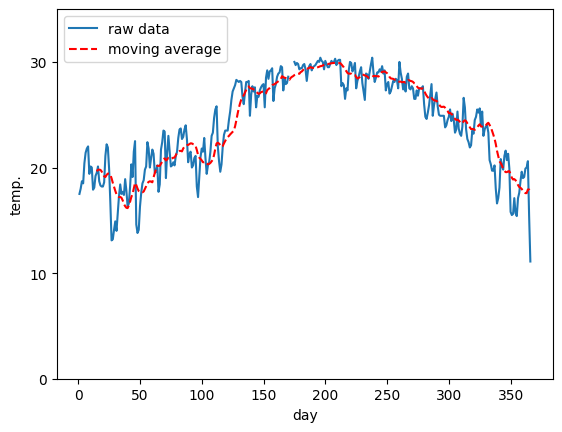

In [13]:
# The NaN value is converted to the mean temp value of June. This is to allow the calculation of moving average.
june_value_mean = df[df['month']==6]["value"].mean()

# This moving average function is obtained from StackOverflow, it accepts list or array as input.
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    print(ret)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Convert NaN values in 'value' to june_value_mean.
value_series=df['value'].fillna(june_value_mean)

# Convert the 'value' dataframe series into a list.
value_values=value_series.values

# Use the moving_average function
value_mov_avg=moving_average(value_values,n=14)

# Prepend fourteen 0 to value_mov_avg to ensure the list having 366 items 
value_mov_avg_withzeroes=np.insert(value_mov_avg, 0, np.repeat(0,13))

#Create a new column with value_move_avg
df['moving average']=value_mov_avg_withzeroes


#Plot graph
plt.plot(df['day_num'],df['value'],label='raw data')
plt.plot(df['day_num'][14:],df['moving average'][14:],'r--',label='moving average') # do not plot the fourteen 0 in the beginning

plt.ylim([0,35])
plt.yticks(np.arange(0,35,10))
plt.legend(loc="upper left")
plt.xlabel('day')
plt.ylabel('temp.')

plt.show()

## Visulize Data - Curve Fit with polynomial functions

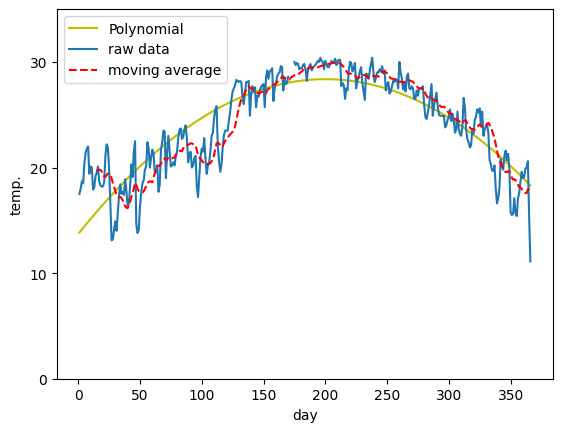

In [14]:
# Define polynomial function.
# I have also demonstrated using a linear function and a cubic polynomial function to fit the curve
def polynomial_function(x, a, b, c):
    return a * x**2 + b * x + c 

# Curve fit
y = df['value'].fillna(june_value_mean)
x = df['day_num']

(popt,pcov) = curve_fit(polynomial_function, x, y) # using the curve fit function
(a,b,c) = popt # obtain the fitted values for the polynomial equation

#plot the curve
x_line = df['day_num']
y_line = polynomial_function(x_line,a,b,c)
plt.plot(x_line,y_line,'y-',label='Polynomial')

plt.plot(df['day_num'],df['value'],label='raw data')
plt.plot(df['day_num'][14:],df['moving average'][14:],'r--',label='moving average')

plt.ylim([0,35])
plt.yticks(np.arange(0,35,10))
plt.legend(loc="upper left")
plt.xlabel('day')
plt.ylabel('temp.')
plt.show()

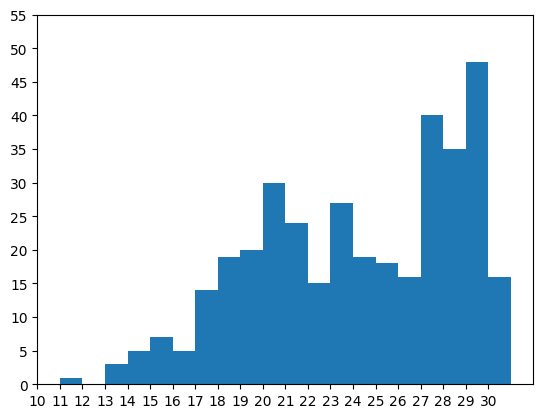

In [15]:
hist_bins=np.arange(11,32,1)

plt.hist(df['value'],bins=hist_bins)
plt.yticks(np.arange(0,60,5))
plt.xticks(np.arange(10,31,1))

plt.show()